# Análisis EDA

**El propósito final de este análisis es definir, para el modelo de recomendación solicitado y las diferentes funciones, para cada conjunto de datos y función, las columnas y datos correspondientes que serán necesarios**. 

Aquí encontrarás un resumen del trabajo realizado en el análisis exploratorio de datos (EDA). <br> 
Para obtener información más detallada y visualizaciones:<br>

[EDA_games](0.%20EDA/EDA_games.ipynb)<br>

[EDA_reviews](02.%20EDA/EDA_reviews.ipynb)<br>

[EDA_items](02.%20EDA/EDA_items.ipynb)<br>

## 2.1 Juegos
En el Análisis EDA, nos centraremos principalmente en:<br>

- buscar valores atípicos
- estadísticas y descripción de los datos
- transformación de datos
- Variables:
    - **item_id**: esta columna contiene el identificador único del juego.
    - **item_name**: este es el nombre del juego.
    - **developer**: es un desarrollador de software especializado en el desarrollo de videojuegos, el proceso y las disciplinas relacionadas con la creación de videojuegos.
    - **publisher**: una editorial de videojuegos es una empresa que publica videojuegos que han sido desarrollados internamente por la editorial o externamente por un desarrollador de videojuegos.
    - **release_year**: es el año en que se lanzó el juego.
    - **genres**: esta columna contiene una lista de géneros para cada juego, que transformaremos con diferentes enfoques.<br>

### Un resumen de lo que encontrarás en el cuaderno:
#### Precio
*   Descubrir si nuestra información de precios tiene valores atípicos.
*   Juegos más caros.
*   Precio promedio de los juegos.
*   Rango de precios.
*   Distribución de precios.
*   Estadísticas de precios.

#### Release Year
*   Rango de años.
*   Juegos lanzados por año.
*   Los cinco años con más juegos lanzados.

#### Publishers
*   Las diez editoriales con la mayor cantidad de juegos publicados.

#### Developers
*   Los diez desarrolladores con la mayor cantidad de juegos publicados.
*   Los desarrolladores menos populares o relevantes, con la menor cantidad de juegos publicados.
*   Las editoriales menos importantes, con la menor cantidad de juegos publicados.

#### Genres
*   Los géneros más populares, con la mayor cantidad de juegos publicados.
*   Los géneros menos populares, con la menor cantidad de juegos publicados.

## Análisis de correlación entre géneros y precios
### ¿Tienen los géneros un impacto en el precio de los juegos?

In [1]:
import json
import os
import pandas as pd
import gzip
import ast
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import seaborn as sns  

## Comenzamos por cargar el dataframe de parquet a pandas 

In [2]:
# Definimos el path al .parquet file
games = 'data/games.parquet'

# Leemos el .parquet file a un DataFrame
df_games = pd.read_parquet(games)

# 2.1 Games

In [3]:
df_games.head(3)

,publisher,genres,title,price,id,developer,release_year
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,4.99,761140,Kotoshiro,2018
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,0.00,643980,Secret Level SRL,2018
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,0.00,670290,Poolians.com,2017


In [4]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22528 entries, 0 to 22527
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     22528 non-null  object 
 1   genres        22528 non-null  object 
 2   title         22528 non-null  object 
 3   price         22528 non-null  float64
 4   id            22528 non-null  int32  
 5   developer     22528 non-null  object 
 6   release_year  22494 non-null  Int64  
dtypes: Int64(1), float64(1), int32(1), object(4)
memory usage: 1.1+ MB


### Comenzaremos normalizando los encabezados para que la misma información en todos los dataframes tenga el mismo nombre.:

| games | reviews | items |
|----------|----------|----------|
| publisher |  |  |
| genres |  |  |
| title |  | item_name |
| price |  |  |
| id | item_id | item_id |
| developer |  |  |
| release_year |  |  |
|  | user_id | user_id |
|  | user_url |  |
|  | helpful |  |
|  | recommend |  |
|  | review_text |  |
|  | date |  |
|  | year |  |
|  |  | playtime_forever |
|  |  | playtime_2weeks |

Entonces renombraremos las columnas en df_games:
* 'id' en juegos a 'item_id'
* 'title' en juegos a 'item_name'

In [5]:
df_games_renamed = df_games.rename(columns={'id': 'item_id', 'title': 'item_name'}, inplace= True)

### También reorganizaremos las columnas en el dataframe para obtener una mejor comprensión y estructura. Más parecido a una base de datos.

In [6]:
# Reasignar el DataFrame con las columnas reordenadas
desired_columns_order = ['item_id', 'item_name', 'developer','publisher','release_year','price','genres']

# Reordenando el orden de las columnas
df_games = df_games[desired_columns_order]

In [7]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22528 entries, 0 to 22527
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       22528 non-null  int32  
 1   item_name     22528 non-null  object 
 2   developer     22528 non-null  object 
 3   publisher     22528 non-null  object 
 4   release_year  22494 non-null  Int64  
 5   price         22528 non-null  float64
 6   genres        22528 non-null  object 
dtypes: Int64(1), float64(1), int32(1), object(4)
memory usage: 1.1+ MB


### Genre

### Género
En esta columna, para cada juego (fila) encontramos una lista de géneros que presenta el juego.<br>
Un **género de videojuego** es una categoría que agrupa juegos según sus objetivos, historia y jugabilidad.<br>
Ayuda a los usuarios y desarrolladores a identificar juegos con estilos y temas similares, como los desafíos intensos en los juegos de acción o el desarrollo de personajes y las misiones en los juegos de rol.<br>
En nuestro df_games, esta columna tiene una lista, necesitamos transformar esta columna para preparar nuestros datos para que sean la entrada de nuestro modelo de recomendación.<br>

Después de muchas consideraciones y búsqueda de soluciones, elegimos entre estos dos enfoques:<br>

1. **Codificación One Hot**:<br>
En este enfoque, creará columnas binarias para cada género único en su conjunto de datos.<br>
Si un juego pertenece a un género en particular, la columna correspondiente tendrá un valor de 1; de lo contrario, tendrá un valor de 0.<br>
Esto es útil cuando el número de géneros únicos es manejable y no demasiado grande.<br>
Puede conducir a una matriz dispersa si hay muchos géneros únicos.<br>
**Ventajas**<br>
- Simple y fácil de implementar.<br>
- Preserva la naturaleza categórica de la columna 'género'.<br>
**Desventajas**
- Puede conducir a una matriz dispersa de alta dimensionalidad, especialmente si hay muchos géneros únicos.<br>
- Puede resultar en un gran número de características, lo que podría aumentar la complejidad computacional y el uso de memoria.<br>
- Puede que no capture las relaciones inherentes entre diferentes géneros.<br>
<br>
En nuestro caso, agregaremos 21 columnas ficticias al conjunto de datos, por lo que para cada item_id (para cada juego) tendremos columnas que indican con un booleano si el juego es o no de la columna de género.<br>
Aquí hay un desglose de cómo se verá el DataFrame resultante de las dummies:<br>
*   Cada fila corresponde a un juego.<br>
*   Cada columna corresponde a un género.<br>
Los valores en el DataFrame son binarios (0 o 1), indicando si un juego pertenece a un género en particular o no.<br>

2. **Explotar y Codificar en Caliente**:
**Ventajas**<br>
- Proporciona información detallada sobre la presencia de cada combinación de géneros en cada juego.<br>
- Captura las interacciones entre diferentes géneros, mejorando potencialmente el rendimiento del modelo.<br>
**Desventajas**<br>
- Aumenta significativamente el tamaño del conjunto de datos, lo que puede afectar los recursos computacionales y el tiempo de entrenamiento.<br>
- Puede conducir al sobreajuste si hay muchas combinaciones únicas de géneros.<br>

Para determinar qué método de codificación es el más adecuado para nuestro sistema de recomendación, consideraremos los siguientes criterios de evaluación:<br>

1. *Rendimiento del Modelo*: Entrenar y evaluar su modelo de clasificación usando cada método de codificación y comparar sus métricas de rendimiento (por ejemplo, precisión, recuperación, puntaje F1).<br>
2. *Eficiencia Computacional*: Medir el tiempo de entrenamiento y el uso de memoria de su modelo con cada método de codificación para asegurarse de que sea factible dado sus recursos computacionales.<br>
3. *Interpretabilidad*: Considere qué tan fácilmente interpretable es el modelo resultante con cada método de codificación, ya que algunos métodos pueden producir representaciones de características más interpretables que otros.<br>
4. *Escalabilidad*: Evaluar si el método de codificación elegido puede escalar efectivamente a medida que el tamaño de su conjunto de datos crece.<br>
<br>
El primer enfoque solo agrega estas 21 columnas que también se pueden reducir después de un análisis detallado. Respecto a la escalabilidad, cada nuevo juego agregará solo un registro a nuestro conjunto de datos. Mientras tanto, con el segundo enfoque, por cada nuevo juego agregaremos tantos géneros como represente este nuevo juego.<br>
Entonces, este es el único criterio que tiene un claro impacto en la comparación por el momento.<br>
<br>
a combination of these factors and the specific requirements and constraints of our recommendation system.<br>
En última instancia, el mejor método de codificación dependerá de unca combinacion de factores y los requerimientos especificos y limitaciones del Modelo de Recomendación<br>
Entonces procederemos con ambos metodos y al avanzar descartaremos el que menos convenga segun la evolucion del Proyecto<br>

### One Hot Encoding

In [8]:
# Funcion para normalizar los  strings en la lista
def normalize_strings(lst):
    normalized = []
    for genre in lst:
        genre = genre.strip().lower().replace('&amp;', '')  # Elimina encabezados/colas  whitespace y convierte en  lowercase
        genre = ' '.join(genre.split())  # Remueve los espacios en blanco
        normalized.append(genre)
    return normalized

In [16]:
df_games1 = df_games.copy()

# Aplicamos  la  funcion a la columna 'genres'
df_games1['genres'] = df_games1['genres'].apply(normalize_strings)

In [17]:
# Convertimos la  lista de genres en comma-separated string
df_games1['genres'] = df_games1['genres'].apply(lambda x: ', '.join(x))

# Creamos las variables dummies
dummies = df_games1['genres'].str.get_dummies(sep=', ')

In [18]:
# Concatenamos los dummies con  df_games1
df_games1 = pd.concat([df_games1, dummies], axis=1)
df_games1.shape

(22528, 28)

In [19]:
df_games1.head()

,item_id,item_name,developer,publisher,release_year,price,genres,action,adventure,animation modeling,...,photo editing,racing,rpg,simulation,software training,sports,strategy,utilities,video production,web publishing
0,761140,Lost Summoner Kitty,Kotoshiro,Kotoshiro,2018,4.99,"action, casual, indie, simulation, strategy",1,0,0,...,0,0,0,1,0,0,1,0,0,0
1,643980,Ironbound,Secret Level SRL,"Making Fun, Inc.",2018,0.00,"free to play, indie, rpg, strategy",0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,670290,Real Pool 3D - Poolians,Poolians.com,Poolians.com,2017,0.00,"casual, free to play, indie, simulation, sports",0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,767400,弹炸人2222,彼岸领域,彼岸领域,2017,0.99,"action, adventure, casual",1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,772540,Battle Royale Trainer,Trickjump Games Ltd,Trickjump Games Ltd,2018,3.99,"action, adventure, simulation",1,1,0,...,0,0,0,1,0,0,0,0,0,0


### Explode and Hot Encode

In [20]:
df_games2 = df_games.copy()
df_games2 = df_games2.explode('genres')
df_games2 = df_games2.dropna(subset=['genres'])
df_games2.head()

,item_id,item_name,developer,publisher,release_year,price,genres
0,761140,Lost Summoner Kitty,Kotoshiro,Kotoshiro,2018,4.99,Action
0,761140,Lost Summoner Kitty,Kotoshiro,Kotoshiro,2018,4.99,Casual
0,761140,Lost Summoner Kitty,Kotoshiro,Kotoshiro,2018,4.99,Indie
0,761140,Lost Summoner Kitty,Kotoshiro,Kotoshiro,2018,4.99,Simulation
0,761140,Lost Summoner Kitty,Kotoshiro,Kotoshiro,2018,4.99,Strategy


In [21]:
df_games2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55609 entries, 0 to 22527
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       55609 non-null  int32  
 1   item_name     55609 non-null  object 
 2   developer     55609 non-null  object 
 3   publisher     55609 non-null  object 
 4   release_year  55527 non-null  Int64  
 5   price         55609 non-null  float64
 6   genres        55609 non-null  object 
dtypes: Int64(1), float64(1), int32(1), object(4)
memory usage: 3.2+ MB


### Ahora vamos a obtener una comprensión más profunda de la información en el dataframe.
Podemos sumergirnos en el contenido y visualización de la información contenida en nuestro dataframe de juegos.

#### Precio
*   Descubrir si nuestra información de precios tiene valores atípicos.
*   Juegos más caros.
*   Precio promedio de los juegos.
*   Rango de precios.
*   Distribución de precios.
*   Estadísticas de precios

#### Analisis de los  outliers de price

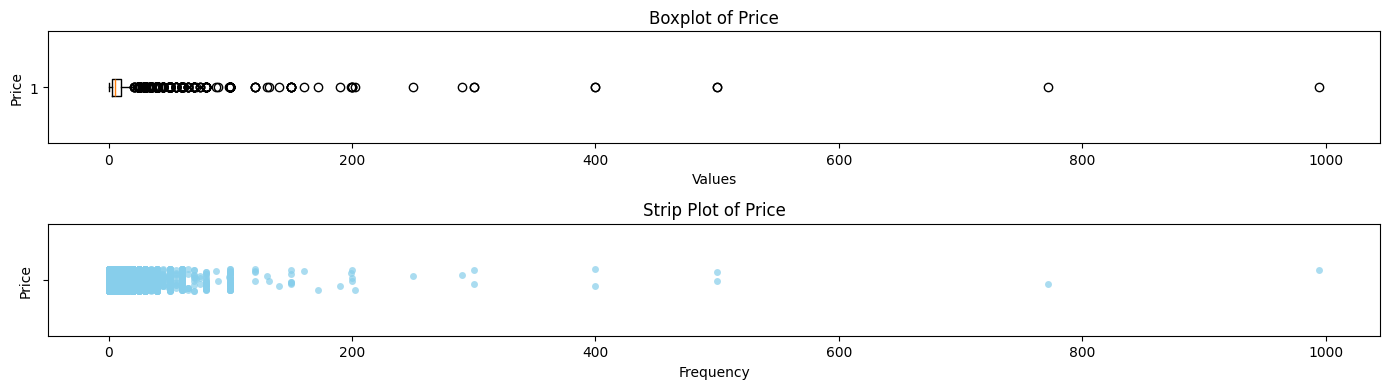

In [22]:
# Z-Score
z_scores = (df_games['price'] - df_games['price'].mean()) / df_games['price'].std()
outliers_zscore = df_games[abs(z_scores) > 3]

# Creamos los  subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 4))

# Boxplot
axs[0].boxplot(df_games['price'], vert=False)
axs[0].set_title('Boxplot of Price')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Price')

# IQR
Q1 = df_games['price'].quantile(0.25)
Q3 = df_games['price'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = df_games[(df_games['price'] < (Q1 - 1.5 * IQR)) | (df_games['price'] > (Q3 + 1.5 * IQR))]

# Strip plot
sns.stripplot(ax=axs[1], x=df_games['price'], color='skyblue', alpha=0.7)
axs[1].set_title('Strip Plot of Price')
axs[1].set_ylabel('Price')
axs[1].set_xlabel('Frequency')

# Ajustamos  layout
plt.tight_layout()

# Show plots
plt.show()

### Distribucion de Price

Average Price for Games with Prices Lower Than 20: 6.763471441394623


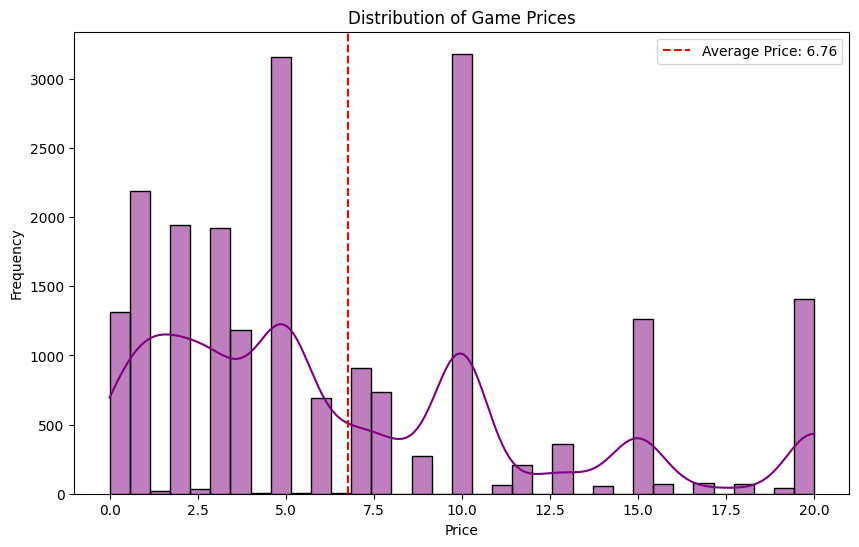

In [23]:
# We will plot the distribution for all games with prices lower than 20
df_prices_lower20 = df_games[df_games['price'] <=20]

# Calculate the average price
average_price_lower20 = df_prices_lower20['price'].mean()
print("Average Price for Games with Prices Lower Than 20:", average_price_lower20)

# Plot distribution of 'price' with KDE curve
plt.figure(figsize=(10, 6))
sns.histplot(df_prices_lower20['price'], kde=True, color='purple')

# Add a vertical line for the average price
plt.axvline(x=average_price_lower20, color='red', linestyle='--', label=f'Average Price: {average_price_lower20:.2f}')

plt.title('Distribution of Game Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

##### Los  games mas costosos

In [ ]:
# games con  prices > 200
df_price_outliers = df_games[df_games['price'] >200]
df_price_outliers

,item_id,item_name,developer,publisher,release_year,price,genres
2046,292180,X-Plane 10 Global - 64 Bit,Laminar Research,Aerosoft GmbH,2014,771.71,[Simulation]
3523,401090,MODO indie 10,The Foundry,The Foundry,2015,299.99,"[Animation &amp; Modeling, Design &amp; Illust..."
6447,585620,GameMaker Studio 2 Mobile,YoYo Games Ltd.,YoYo Games Ltd.,2017,399.99,"[Animation &amp; Modeling, Design &amp; Illust..."
6448,585610,GameMaker Studio 2 UWP,YoYo Games Ltd.,YoYo Games Ltd.,2017,399.99,"[Animation &amp; Modeling, Design &amp; Illust..."
8452,719000,Strata Spaces VR – Professional Edition Upgrade,"Strata Mixed Reality, Inc.","Strata Mixed Reality, Inc.",2017,995.00,"[Animation &amp; Modeling, Design &amp; Illust..."
9917,691560,CUR3D Maker Edition - Permission for commercia...,RUHRSOURCE GmbH,RUHRSOURCE GmbH,2017,499.99,"[Animation &amp; Modeling, Design &amp; Illust..."
10669,442120,Pinball FX3,Zen Studios,Zen Studios,2017,202.76,[Simulation]
12288,629795,EVE Online: 7430 PLEX,CCP,CCP,2017,249.99,"[Free to Play, Massively Multiplayer, RPG]"
12289,629796,EVE Online: 15400 PLEX,CCP,CCP,2017,499.99,"[Free to Play, Massively Multiplayer, RPG]"
18290,366190,CopperCube - Professional Edition,Ambiera e.U.,Ambiera e.U.,2015,289.99,"[Animation &amp; Modeling, Design &amp; Illust..."


#### Identificamos a los  games con price > 20  

In [25]:
price = 20
print('There are ', df_games['price'][df_games['price'] > price].count(),' with prices higher than', price)
print('These represent ', round(df_games['price'][df_games['price'] > price].count()/df_games['price'].count(),2)*100,'% of all games')

There are  1361  with prices higher than 20
These represent  6.0 % of all games


In [26]:
df_games['price'].describe()

count    22528.000000
mean         8.965454
std         15.415013
min          0.000000
25%          2.990000
50%          4.990000
75%          9.990000
max        995.000000
Name: price, dtype: float64

### Estadísticas de Precios
* Podemos observar que los precios de los juegos varían desde gratuitos hasta 995.
* La mayoría de los juegos, alrededor del 94%, tienen precios inferiores a 20.
* Solo hay 1361 juegos con precios superiores a 20, estos no pueden considerarse como valores atípicos ya que podrían ser aplicaciones costosas.

#### Release Year
*   Rango de años.
*   Juegos lanzados por año.
*   Los cinco años con más juegos lanzados.


In [27]:
# Agrupar por 'release_year' y contar el número de juegos lanzados cada año
juegos_por_año = df_games['release_year'].value_counts().sort_index()

# Convertir la Serie a un DataFrame
juegos_por_año_df = pd.DataFrame(juegos_por_año)

# Restablecer el índice para hacer que 'release_year' sea una columna
juegos_por_año_df.reset_index(inplace=True)

# Renombrar las columnas
juegos_por_año_df.columns = ['año_lanzamiento', 'num_juegos']

# Mostrar el DataFrame
juegos_por_año_df.sort_values(by='num_juegos',ascending= False).head()

,release_year,num_games
34,2017,7236
33,2016,5105
32,2015,3506
31,2014,1973
30,2013,1232


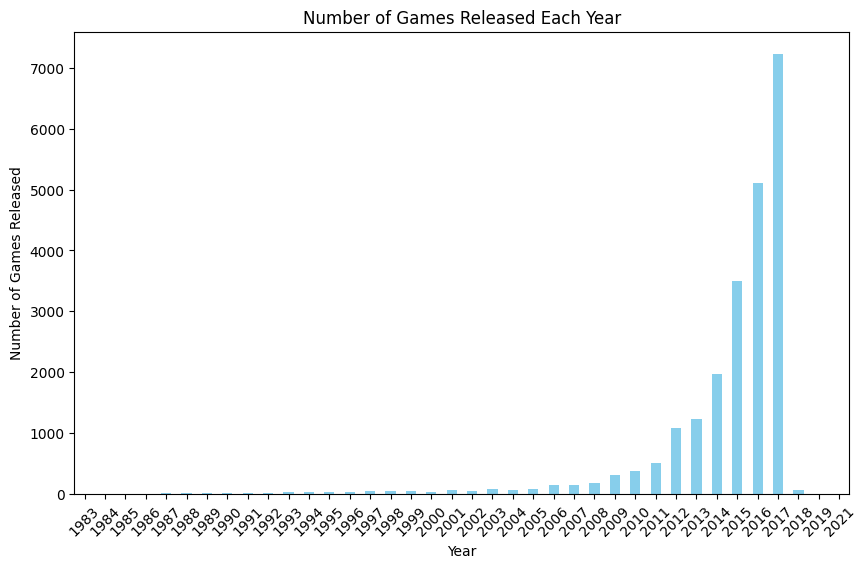

In [21]:
# Plot the number of games released each year
plt.figure(figsize=(10, 6))
games_per_year.plot(kind='bar', color='skyblue')
plt.title('Number of Games Released Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Games Released')
plt.xticks(rotation=45)
plt.show()

##### Top cinco years con mas released games

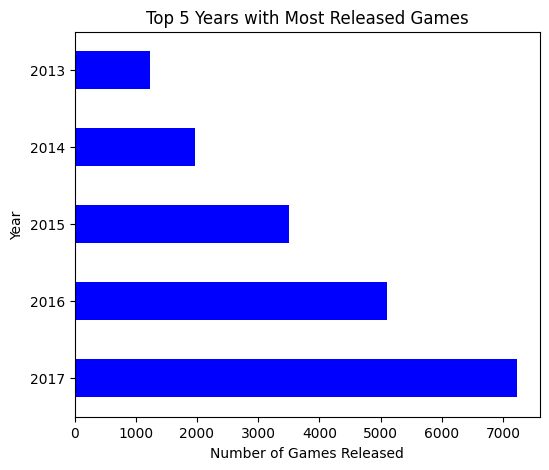

In [28]:
# Find the top 5 years with the most released games
top_5_years = games_per_year.nlargest(5)

# Plot the top 5 years with the most released games in a horizontal bar chart
plt.figure(figsize=(6, 5))
top_5_years.plot(kind='barh', color='blue')
plt.title('Top 5 Years with Most Released Games')
plt.xlabel('Number of Games Released')
plt.ylabel('Year')
plt.show()

##### Release Year
* Hay un total de 22,528 juegos publicados entre 1983 y 2021.
* El **año 2017** fue el año que tuvo más juegos lanzados, con **7,236 juegos**.
* La mayoría de los juegos fueron lanzados entre **2007 y 2017**.

#### Publishers
*   Las diez editoriales con la mayor cantidad de juegos publicados.

In [29]:
# Total Number of publishers
print('There are',df_games['publisher'].nunique())

There are 7834


In [30]:
# Group by 'publisher' and count the number of games released by each publisher
games_per_publisher = df_games['publisher'].value_counts().sort_index()

# Convert the Series to a DataFrame
games_per_publisher_df = pd.DataFrame(games_per_publisher)

# Reset the index to make 'publisher' a column
games_per_publisher_df.reset_index(inplace=True)

# Rename the columns
games_per_publisher_df.columns = ['publisher', 'num_games']

# Calculate the total number of games
total_games = df_games['item_id'].count()

# Add a percentage column to the DataFrame
games_per_publisher_df['percentage'] = round((games_per_publisher_df['num_games'] / total_games),2) * 100

# Display the DataFrame
games_per_publisher_df.sort_values(by='num_games', ascending=False).head(10)

,publisher,num_games,percentage
6902,Ubisoft,366,2.0
1928,Dovetail Games - Trains,358,2.0
1752,Degica,266,1.0
4881,Paradox Interactive,262,1.0
1924,Dovetail Games - Flight,220,1.0
5662,SEGA,215,1.0
254,Activision,201,1.0
824,Big Fish Games,194,1.0
3526,"KOEI TECMO GAMES CO., LTD.",192,1.0
3514,KISS ltd,177,1.0


##### Top 10 publishers

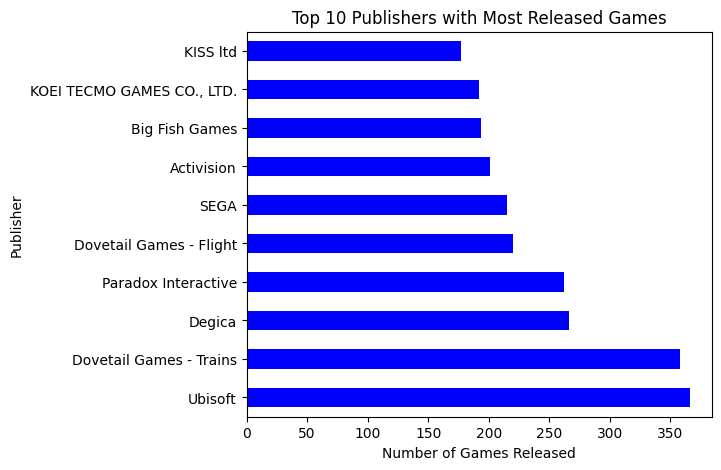

In [31]:
# Find the top 10 publishers  with the most released games
top_10_publishers = games_per_publisher.nlargest(10)

# Plot the top 5 years with the most released games in a horizontal bar chart
plt.figure(figsize=(6, 5))
top_10_publishers.plot(kind='barh', color='blue')
plt.title('Top 10 Publishers with Most Released Games')
plt.xlabel('Number of Games Released')
plt.ylabel('Publisher')
plt.show()

##### Publishers

* Hay un total de 9,070 editores diferentes que han publicado juegos.
* **Valve Corporation** es el editor que ha lanzado la mayor cantidad de juegos, con un total de **2,578 juegos**.
* Los diez principales editores representan aproximadamente el **26%** del total de juegos en el dataset.

#### Developers

*   Los diez desarrolladores con la mayor cantidad de juegos publicados.
*   Los desarrolladores menos populares o relevantes, con la menor cantidad de juegos publicados.
*   Las editoriales menos importantes, con la menor cantidad de juegos publicados.

In [ ]:
# Total de developers
print('There are',df_games['developer'].nunique())

There are 10275


In [33]:
# Group by 'developer' and count the number of games released by each developer
games_per_developer = df_games['developer'].value_counts().sort_index()

# Convert the Series to a DataFrame
games_per_developer_df = pd.DataFrame(games_per_developer)

# Reset the index to make 'developer' a column
games_per_developer_df.reset_index(inplace=True)

# Rename the columns
games_per_developer_df.columns = ['developer', 'num_games']

# Calculate the total number of games
total_games = df_games['item_id'].count()

# Add a percentage column to the DataFrame
games_per_developer_df['percentage'] = round((games_per_developer_df['num_games'] / total_games),4) * 100

# Display the DataFrame
games_per_developer_df.sort_values(by='num_games', ascending=False).head(10)

,developer,num_games,percentage
2566,Dovetail Games,253,1.12
4673,"KOEI TECMO GAMES CO., LTD.",180,0.80
9073,Ubisoft - San Francisco,178,0.79
1529,Capcom,107,0.47
6422,Paradox Development Studio,97,0.43
8107,Stainless Games,83,0.37
2130,DL Softworks,78,0.35
7147,"Relic Entertainment,Feral Interactive (Mac),Fe...",77,0.34
1677,Choice of Games,76,0.34
7422,SCS Software,73,0.32


##### Top 10 Developers

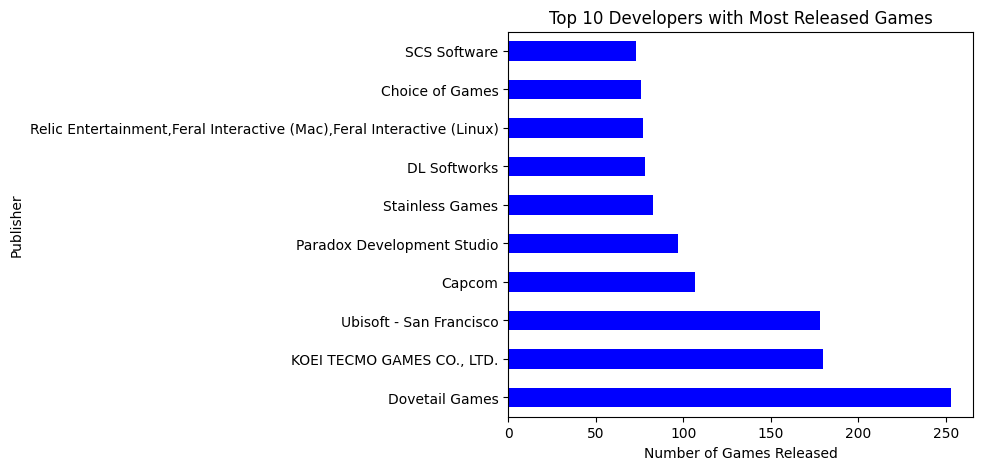

In [34]:
# Find the top 10 developers  with the most released games
top_10_developers = games_per_developer.nlargest(10)

# Plot the top 5 years with the most released games in a horizontal bar chart
plt.figure(figsize=(6, 5))
top_10_developers.plot(kind='barh', color='blue')
plt.title('Top 10 Developers with Most Released Games')
plt.xlabel('Number of Games Released')
plt.ylabel('Publisher')
plt.show()

##### Developers
-   Hay un total de 17,159 desarrolladores diferentes que han lanzado juegos.
-   Ubisoft es el desarrollador que ha lanzado la mayor cantidad de juegos, con un total de 387 juegos.
-   Los diez principales desarrolladores representan aproximadamente el 3.79% del total de juegos en el conjunto de datos.

#### Genres
*   Los géneros más populares, con la mayor cantidad de juegos publicados.
*   Los géneros menos populares, con la menor cantidad de juegos publicados.

In [35]:
# Total Number of genress
print('There are',df_games2['genres'].nunique())

There are 21


In [36]:
# Agrupar por 'genres' y contamos el numero de juegos lanzados por ano
games_per_genre = df_games2['genres'].value_counts().sort_index()

# Convertimos la serie en  DataFrame
games_per_genres_df = pd.DataFrame(games_per_genre)
#genres  index para converitr a 'developer' en columan
games_per_genres_df.reset_index(inplace=True)

# Renombramos la columna
games_per_genres_df.columns = ['genres', 'num_games']

# Calculamos el total de  games
total_games = df_games2['item_id'].count()

# Agregamos el porcentage columna al DataFrame
games_per_genres_df['percentage'] = round((games_per_genres_df['num_games'] / total_games),4) * 100

# DataFrame
sorted_games_per_genres = games_per_genres_df.sort_values(by='num_games', ascending=False)
sorted_games_per_genres.head(10)

,genres,num_games,percentage
9,Indie,12693,22.83
0,Action,9429,16.96
1,Adventure,7021,12.63
4,Casual,6283,11.30
17,Strategy,5213,9.37
14,Simulation,4723,8.49
12,RPG,3809,6.85
8,Free to Play,1458,2.62
6,Early Access,1360,2.45
16,Sports,1031,1.85


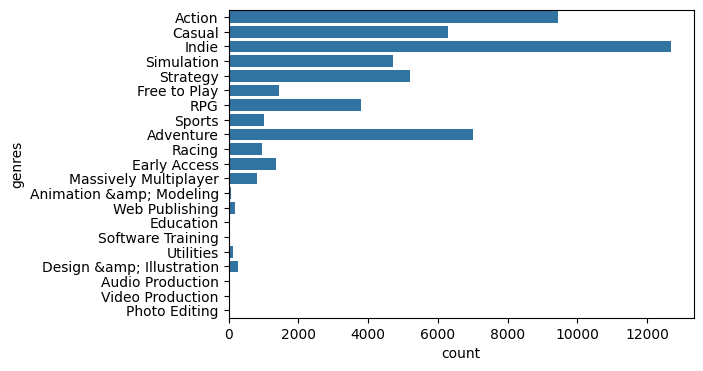

In [37]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_games2, y='genres', orient='h')
plt.show()

##### Least frequent genres

In [38]:
# Least occuring genres
sorted_games_per_genres = games_per_genres_df.sort_values(by='num_games', ascending=True)
sorted_games_per_genres.head(10)

,genres,num_games,percentage
11,Photo Editing,11,0.02
19,Video Production,18,0.03
3,Audio Production,30,0.05
15,Software Training,36,0.06
7,Education,53,0.10
2,Animation &amp; Modeling,83,0.15
18,Utilities,139,0.25
20,Web Publishing,195,0.35
5,Design &amp; Illustration,264,0.47
10,Massively Multiplayer,813,1.46


##### Genres
* Hay 21 *géneros*
* Cada juego puede tener múltiples géneros*
* El 95% de todos los juegos se pueden clasificar en las 10 categorías principales:*
    1. Action
    2. Casual
    3. Indie
    4. Simulation
    5. Startegy
    6. Free to play
    7. RPG
    8. Sports
    9. Adventure
    10. Racing

## ¿Tienen los géneros impacto en el precio de los juegos? 
Para esto, utilizaremos el dataframe df_games1 ya que está preparado para ser utilizado tal como está en nuestro análisis de correlación.<br>
Por lo tanto, realizaremos un análisis de correlación entre los precios y los géneros de los juegos.

##### Análisis de correlación: Calcular los coeficientes de correlación entre las variables de género codificadas y la variable 'precio' para identificar cualquier correlación.

In [40]:
# Preparando el df para el análisis de correlación por géneros y precio
df_games1_corr = df_games1.copy()
df_games1_corr.drop(['item_id','developer','publisher','release_year','item_name','genres'], axis=1, inplace= True)

# Análisis de correlación
# Calcular la matriz de correlación
correlation_matrix = df_games1_corr.corr()

# Filtrar la matriz de correlación para incluir únicamente correlaciones con 'precio'
price_correlation = correlation_matrix['price']

##### Visualización: Visualizar los resultados de la correlación utilizando un mapa de calor para facilitar la interpretación de las relaciones entre los géneros y los precios.

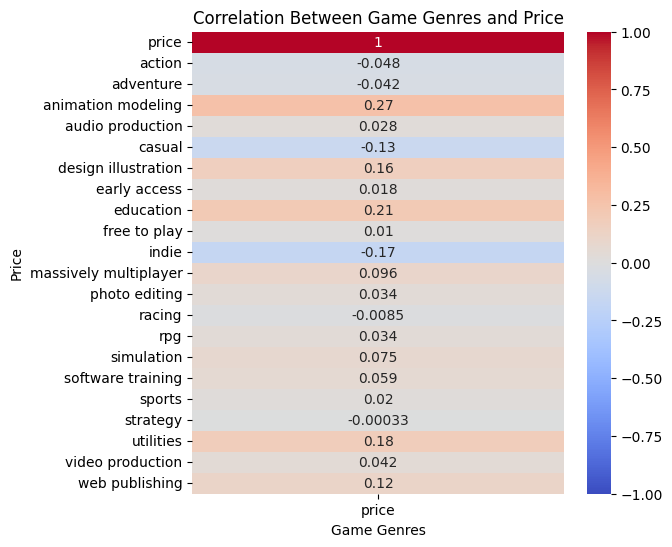

In [41]:
# Visualization
# Plot correlation heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(price_correlation.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Game Genres and Price')
plt.xlabel('Game Genres')
plt.ylabel('Price')
plt.show()

### Item_id
Esta columna anteriormente era la columna 'id' renombrada como 'item_id' para que coincida con los otros conjuntos de datos. En esta columna encontramos el identificador único del artículo para cada uno de los juegos en el conjunto de datos. Este item_id debe ser único para cada juego y durante nuestro proceso ETL nos aseguramos de que fuera único, eliminamos y eliminamos duplicados. Ahora obtendremos algunas ideas:

In [42]:
df_games['item_id'].count()

22528

### Guardamos el games Dataframe con las diferentes transformacions de la columna genres para el modelo de recomendacion 
We choose to store the data as .parquet beacuse of the size limitations<br>

In [ ]:
# Define la ruta del archivo para almacenar el archivo Parquet
games = 'datos/games.parqu1et'
games2 = 'datos/games2.parquet'

# Almacena el DataFrame como un archivo Parquet
df_games.to_parquet(games, index=Fal1se)
df_games2.to_parquet(games2, index=False)

# Imprime un mensaje confirmando la ubicación de almacenamiento
print(f'El DataFrame de juegos fue almacenado en {games1}')
print(f'El DataFrame de juegos fue almacenado en {games2}')

games DataFrame was stored into data/games1.parquet
games DataFrame was stored into data/games2.parquet
